# PLOTTING NOTEBOOK

A notebook to produce and view simple plots of the data produced during experiments.

N.B.: Make sure this notebook is in the repo root.

## Imports!

In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Select an experiment subfolder

Use tha variable below to select an experiment to plot.
Type in the name of a subfolder of saves.

In [2]:
# experiment_subfolder = "2021_02_16_20_12_41"   # <--- edit this
experiment_subfolder = "2021_02_17_20_47_23"   # <--- edit this

main_dir = Path("saves") / experiment_subfolder

# Episode returns

Cartesian plots of episode returns, for either training or test episodes

## Reading files

Go around all the "ep*" subfolders, find the episode info files with a given name, for each file compute the average return and insert it into a list as that epoch's return. End when an empty or nonexistent folder is found.

In [3]:
def find_epochs():
    max_epoch=-1
    for fldr in main_dir.iterdir():
        if fldr.is_dir():
            m = re.match(r"^ep([0-9]+)$", fldr.name)
            if m:
                epoch = int(m.group(1))
                max_epoch = max(epoch, max_epoch)
    return max_epoch

def return_from_line(line):
    tokens = line.split('\t')
    # elemento 0 : episode_duration (inutile, sempre costante in HumanoidStandup)
    # elemento 1 : episode_return (utile)
    return float(tokens[1])

def read_returns(fname):
    epochs = find_epochs()
    returns = []
    for epoch in range(epochs):   # esclude l'ultima cartella, ma pazienza, tanto è sempre vuota
        epoch_dir = main_dir / "ep{}".format(epoch)
        if not epoch_dir.exists():
            break
        file_path = epoch_dir / fname
        if not file_path.exists():
            break
        with open(file_path, 'r') as f:
            lines = f.readlines()
        lines.pop(0)   # la prima riga è di intestazione, togliamola
        # recuperiamo i ritorni dalle righe
        this_epoch_returns = list(map(return_from_line, lines))
        # facciamo la media
        this_epoch_avg_return = np.mean(this_epoch_returns)
        # e infine
        returns.append(this_epoch_avg_return)
    return returns

## Plot stats (generic)

With matplotlib.

The "raw" plot will likely be very noisy, so I'll define a smoothed one too.

In [4]:
def plot_data(series, title, ylabel, xlabel="Episode", smoothing_window=None):
    # prima i dati raw...
    plt.figure(figsize=(10,5))
    plt.plot(series)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # recuperiamo il range dell'asse y per riutilizzarlo nella seconda parte
    ylim = plt.ylim()
    plt.show()
    # ...poi smoothed
    if smoothing_window!=None:
        plt.figure(figsize=(10,5))
        # a dispetto del suo nome, "series" il più delle volte entra come lista
        smoothed_series = pd.Series(series).rolling(smoothing_window, min_periods=smoothing_window).mean()
        # impostiamo il range dell'asse y allo stesso di prima
        plt.ylim(ylim)
        plt.plot(smoothed_series)
        plt.xlabel(xlabel)
        plt.ylabel("Smoothed "+ylabel)
        plt.title(title+", smoothed with window size {}".format(smoothing_window))
        plt.show()

## Main

Let's actually do something now.

Use the variable below to select which episodes to plot: train or test

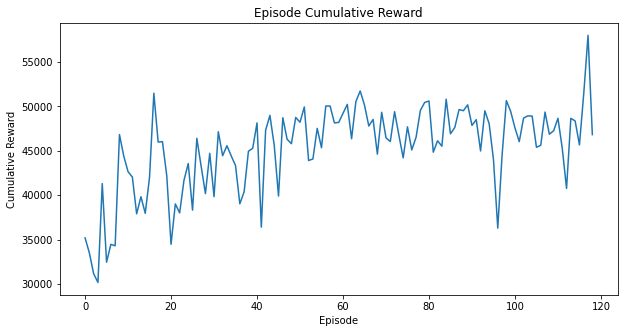

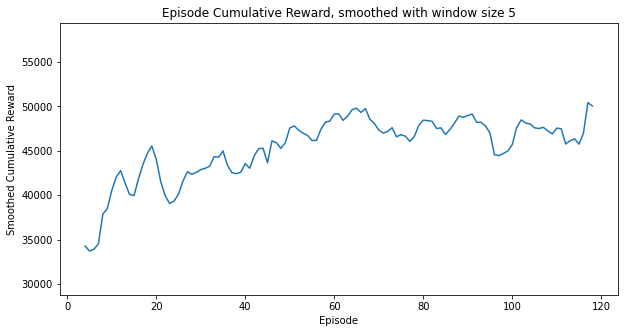

In [11]:
stats_filename = "ep_stats.txt"   # <--- CHOOSE "ep_stats.txt" OR "test_ep_stats.txt"

returns = read_returns(stats_filename)

plot_data(returns, "Episode Cumulative Reward", "Cumulative Reward", smoothing_window=5)

# Losses

Cartesian plots for the loss of policy, q1 and q2

## Reading files

Go around all the "ep*" subfolders, find the loss info files, for each file insert the data into lists as that epoch's losses. End when an empty or nonexistent folder is found.

In [6]:
# Posso riutilizzare find_epochs direttamente

def losses_from_line(line):
    tokens = line.split('\t')
    # elemento 0 : policy_loss
    # elemento 1 : q1_loss
    # elemento 2 : q2_loss
    # return float(tokens[0]), float(tokens[1]), float(tokens[2])
    return list(map(float, tokens))

def read_losses():
    epochs = find_epochs()
    policy_losses = []
    q1_losses = []
    q2_losses = []
    for epoch in range(epochs):   # esclude l'ultima cartella, ma pazienza, tanto è sempre vuota
        epoch_dir = main_dir / "ep{}".format(epoch)
        if not epoch_dir.exists():
            break
        file_path = epoch_dir / "losses.txt"
        if not file_path.exists():
            break
        with open(file_path, 'r') as f:
            lines = f.readlines()
        # stavolta abbiamo necessariamente una sola riga (di dati), quindi è facile
        # basta che ci ricordiamo che lines[0] è ancora l'intestazione
        this_epoch_losses = losses_from_line(lines[1])
        # e poi basta appendere
        policy_losses.append(this_epoch_losses[0])
        q1_losses.append(this_epoch_losses[1])
        q2_losses.append(this_epoch_losses[2])
    return policy_losses, q1_losses, q2_losses

## Plot stats

No need, the generic functions from the previous section will suffice

## Main

Let's actually do something now.

Use the variable below to select which loss to plot: policy, q1 or q2

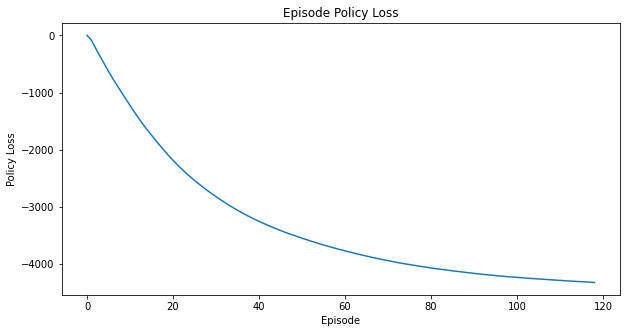

In [7]:
nn_index = 0   # <--- CHOOSE 0(Policy) OR 1(Q1) OR 2(Q2)

nn_names = ("Policy", "Q1", "Q2")

losses = read_losses()

plot_data(losses[nn_index], "Episode {} Loss".format(nn_names[nn_index]), "{} Loss".format(nn_names[nn_index]))